# Import Requirements

In [2]:
import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave , imwrite
from pathlib import Path 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
import os
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")


import tensorflow as tf
import tensorflow.keras  as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import cv2 as cv


In [3]:
!pip install segmentation-models-3D
import segmentation_models_3D as sm

Segmentation Models: using `tf.keras` framework.


# Data Preprocessing

## Define custom DataGenerator

In [4]:
def load_image(dir_name,image_list):
    images=[]
    for i , image_name in enumerate(image_list):
        image_name=image_name+'/'+image_name
        flair=nib.load(dir_name+image_name+'_flair.nii').get_fdata()
        flair=scaler.fit_transform(flair.reshape(-1, flair.shape[-1])).reshape(flair.shape)
        t1ce=nib.load(dir_name+image_name+'_t1ce.nii').get_fdata()
        t1ce=scaler.fit_transform(t1ce.reshape(-1, t1ce.shape[-1])).reshape(t1ce.shape)
        t2=nib.load(dir_name+image_name+'_t2.nii').get_fdata()
        t2=scaler.fit_transform(t2.reshape(-1, t2.shape[-1])).reshape(t2.shape)
        
        temp_combined_images = np.stack([flair, t1ce,t2], axis=3)
        temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
        images.append(temp_combined_images)
            
    images=np.array(images)
    
    return(images)

In [5]:
def load_mask(dir_name,image_list):
    masks=[]
    for image_name in image_list:
        image_name=image_name+'/'+image_name
        if image_name == 'BraTS20_Training_355/BraTS20_Training_355':
            temp_mask= nib.load(dir_name + 'BraTS20_Training_355/W39_1998.09.19_Segm.nii').get_fdata()
        else :
            temp_mask=nib.load(dir_name+image_name+'_seg.nii').get_fdata()
        temp_mask=temp_mask.astype(np.uint8)
        temp_mask[temp_mask==4] = 3 
        temp_mask = temp_mask[56:184, 56:184, 13:141]
        
        temp_mask= to_categorical(temp_mask, num_classes=4)
        
        masks.append(temp_mask)
    
    masks=np.array(masks)
    return(masks)

In [6]:
def ImageLoader(img_dir,img_list,mask_dir,mask_list, batch_size=16):
    size=len(img_list)
    i=0
    while True:
        batch_start=0
        batch_end=batch_size
        while batch_start< size:
            end=min(batch_end,size)
            X=load_image(img_dir, img_list[batch_start:end])
            
            Y=load_mask(mask_dir, mask_list[batch_start:end])
            
            yield (X,Y)    
            batch_start += batch_size   
            batch_end += batch_size

In [7]:
train_img_dir='BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
train_masks_dir='BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

In [8]:
img_list=sorted(os.listdir(path='BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'))
mask_list=sorted(os.listdir(path='BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'))

In [9]:
train_data, val_data = train_test_split(img_list,test_size=0.2) 

In [10]:
batch_size=1
steps_per_epoch = len(train_data)//batch_size
val_steps_per_epoch=len(val_data)//batch_size

In [11]:
train_img_datagen = ImageLoader(train_img_dir, train_data, 
                                train_masks_dir, train_data, batch_size)
val_img_datagen = ImageLoader(train_img_dir, val_data, 
                                train_masks_dir, val_data, batch_size)

# Build Unet Model

### Losses 
* **Dice loss**
    * Dice coefficient , which is essentially a measure of overlap between two samples. This measure ranges from 0 to 1 where a Dice coefficient of 1 denotes perfect and complete overlap.
    * $Dice loss = 1-Dice coeff$
* **Categorical Focal loss**
    * Focal loss is said to perform better than Cross-Entropy loss in many cases.
    * $Focalloss=-\sum_{i=0}^n(i-p_i)^y log_b(p_i)$
    

In [12]:
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5),dice_loss]

LR = 0.0001
optim = keras.optimizers.Adam(LR)

### Metrics
* **Accuracy** 
    * $ Acc=\frac{TP+TN}{TP+TN+FP+FN}$
* **MeanIOU** 
    * $ IOU=\frac{TP}{TP+FP+FN}$
* **DiceCoeff** 
    * $ Dice=\frac{2TP}{2TP+FP+FN}$
* **precision** 
    * $ Prec=\frac{TP}{TP+FP}$
* **sensitivity** 
    * $ Sens=\frac{TP}{TP+FN}$
* **specificity** 
    * $ Spec=\frac{TP}{TP+TN+FP+FN}$



In [13]:
from losses_and_metrics import dice_coef , dice_coef_edema , dice_coef_enhancing, dice_coef_necrotic , sensitivity, specificity, precision
from UnetModel import Unet3d

In [14]:
import pydot 
import graphviz

In [15]:
model = Unet3d(IMG_HEIGHT=128, 
                          IMG_WIDTH=128, 
                          IMG_DEPTH=128, 
                          IMG_CHANNELS=3, 
                          num_classes=4)


### Callbacks

In [16]:
early_stopper=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3
)

reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
)
tensorboard_clbk=tf.keras.callbacks.TensorBoard(
    log_dir='logs',
    write_graph=True,
    update_freq='epoch',
)

### Train the Model

In [17]:
# history=model.fit( train_img_datagen,
#          steps_per_epoch=steps_per_epoch,
#          epochs=10,
#          verbose=1,
#            callbacks=[reduce_lr, early_stopper,tensorboard_clbk],
#           validation_data=val_img_datagen,
#           validation_steps=len(val_data)
#         )


#model.save('unet3d_0.h5')

### Load Model

In [18]:
model=load_model('unet3d_0.h5',compile=False)

In [19]:
model.compile(loss=total_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )

## Test

In [94]:
from predictor import predict_for 
import random

In [21]:
flair=nib.load('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_033/BraTS20_Training_033_flair.nii').get_fdata()
t2=nib.load('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_033/BraTS20_Training_033_t2.nii').get_fdata()
t1ce=nib.load('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_033/BraTS20_Training_033_t1ce.nii').get_fdata()

In [22]:
mask=nib.load('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_033/BraTS20_Training_033_seg.nii').get_fdata()

In [23]:
res=predict_for(flair,t2,t1ce,model)

1/1 [==============================] - 21s 21s/step


In [97]:
def predict_for(flair, t2, t1ce, model):
    flair = scaler.fit_transform(flair.reshape(-1, flair.shape[-1])).reshape(
        flair.shape
    )
    t1ce = scaler.fit_transform(t1ce.reshape(-1, t1ce.shape[-1])).reshape(t1ce.shape)
    t2 = scaler.fit_transform(t2.reshape(-1, t2.shape[-1])).reshape(t2.shape)
    temp_combined_images = np.stack([flair, t1ce, t2], axis=3)
    temp_combined_images = temp_combined_images[56:184, 56:184, 13:141]

    inp = np.expand_dims(temp_combined_images, axis=0)

    ##predicting

    res = model.predict(inp)
    print(np.unique(res))
    return res

In [98]:
def random_predictor(model):
    path_ = "BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"
    n = random.randint(100, 369)
    flair = nib.load(
        f"BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{n}/BraTS20_Training_{n}_flair.nii"
    ).get_fdata()
    t2 = nib.load(
        f"BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{n}/BraTS20_Training_{n}_t2.nii"
    ).get_fdata()
    t1ce = nib.load(
        f"BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{n}/BraTS20_Training_{n}_t1ce.nii"
    ).get_fdata()

    mask=nib.load(f'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{n}/BraTS20_Training_{n}_seg.nii').get_fdata()
    
    temp_mask=mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3 
    temp_mask = temp_mask[56:184, 56:184, 13:141]
    mask= to_categorical(temp_mask, num_classes=4)
    

    res = predict_for(flair, t2, t1ce, model)
    print(np.unique(res))
    fig, ax = plt.subplots(2, 4)
    s = random.randint(40, 100)
    ax[0, 0].imshow(res[0, :, :, s, 0], cmap="gray")
    ax[0,0].axis(False)
    ax[0,0].set_title('whole tumor')
    ax[0, 1].imshow(res[0, :, :, s, 1], cmap="gray")
    ax[0,1].axis(False)
    ax[0,1].set_title('necrotic/core')
    ax[0, 2].imshow(res[0, :, :, s, 2], cmap="gray")
    ax[0,2].axis(False)
    ax[0,2].set_title('edema')
    ax[0, 3].imshow(res[0, :, :, s, 3], cmap="gray")
    ax[0,3].axis(False)
    ax[0,3].set_title('enhancing')
    
    ax[1, 0].imshow(mask[ :, :, s, 0], cmap="gray")
    ax[1,0].axis(False)
    ax[1,0].set_title('whole tumor')
    ax[1, 1].imshow(mask[ :, :, s, 1], cmap="gray")
    ax[1,1].axis(False)
    ax[1,1].set_title('necrotic/core')
    ax[1, 2].imshow(mask[ :, :, s, 2], cmap="gray")
    ax[1,2].axis(False)
    ax[1,2].set_title('edema')
    ax[1,3].imshow(mask[ :, :, s, 3], cmap="gray")
    ax[1,3].axis(False)
    ax[1,3].set_title('enhancing')

    return res

1/1 [==============================] - 0s 371ms/step
[0.0000000e+00 1.1759931e-38 1.1761724e-38 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
[0.0000000e+00 1.1759931e-38 1.1761724e-38 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]


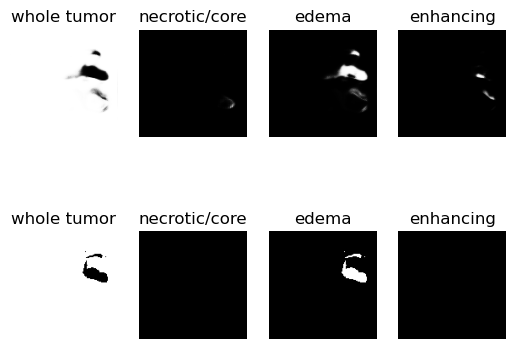

In [99]:
res=random_predictor(model)

# Evaluate

In [45]:
res=model.evaluate(val_img_datagen, steps=len(val_data))
print(res)

74/74 [==============================] - 181s 2s/step - loss: 0.8491 - accuracy: 0.9706 - mean_io_u: 0.7482 - dice_coef: 1.0000 - precision: 0.9710 - sensitivity: 0.9703 - specificity: 0.9903 - dice_coef_necrotic: 1.0000 - dice_coef_edema: 1.0000 - dice_coef_enhancing: 1.0000


[0.8490826487541199,
 0.9705536365509033,
 0.7482298016548157,
 0.9999657869338989,
 0.9709919095039368,
 0.9703109264373779,
 0.9903402328491211,
 0.9999998807907104,
 1.0,
 1.0]

* **Mean IOU score = 0.7482**
* **Accuracy = 97.06%**
* **Precision = 97.1%**

In [125]:
def save_tiff(res,dir_):
    for i in range(res.shape[1]):
        img=res[0,:,:,i,2]
        cv.imwrite(f'{dir_}/{i}.tiff',img)

In [ ]:
save_tiff(res,'ss')

In [130]:
import cv2 as cv

In [66]:
def show_all_slices(res_):
    for i in range(res_.shape[2]):
        cv.imshow("",res_[0,:,:,i,2])

        if  cv.waitKey(50) & 0xFF==ord("d"):
            break
    cv.destroyAllWindows()
        
        

In [69]:
show_all_slices(res)

In [ ]:
d